In [ ]:
!git clone "https://github.com/aminul-huq/Speech-Command-Classification.git"

fatal: destination path 'Speech-Command-Classification' already exists and is not an empty directory.


In [ ]:
%cd Speech-Command-Classification/

/content/Speech-Command-Classification


In [ ]:
%mkdir "data1"

mkdir: cannot create directory ‘data1’: File exists


In [ ]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset
import torchaudio
from torchaudio import transforms
from torch import Tensor

# from torchaudio.datasets.utils import (
#     download_url,
#     extract_archive,
#     walk_files
# )

from train_utils import *
from model import *
# from dataloader import *

In [ ]:
class SpeechDataLoader(Dataset):
    
    def __init__(self,data,labels,list_dir,transform=None):
        self.data = data
        self.labels = labels
        self.label_dict = list_dir
        self.transform = transform
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        waveform = self.data[idx]
        
        if self.transform != None:
            waveform = self.transform(waveform)

        if self.labels[idx] in self.label_dict:
            out_labels = self.label_dict.index(self.labels[idx])
            

        return waveform, out_labels

class SpeechDataLoaderSoft(Dataset):
    def __init__(self,data,labels,list_dir,transform,softlabels):
        self.data = data
        self.labels = labels
        self.label_dict = list_dir
        self.transform = transform
        self.soft_labels = softlabels.float()
    
    def __len__(self):
        return len(self.data)   

    def __getitem__(self,idx):
        waveform = self.data[idx]
        soft_labels = self.soft_labels[idx]
        
        if self.transform != None:
            waveform = self.transform(waveform)

        if self.labels[idx] in self.label_dict:
            out_labels = self.label_dict.index(self.labels[idx])
            
        return waveform, out_labels, soft_labels, idx


In [ ]:
dataset = torchaudio.datasets.SPEECHCOMMANDS('./data1/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)

In [ ]:
train_audio_path = './data1/SpeechCommands/speech_commands_v0.02/'

labels_dict=os.listdir(train_audio_path)

a = torchaudio.datasets.SPEECHCOMMANDS('./data1/' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'SpeechCommands', download = True)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


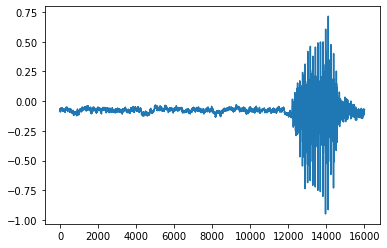

In [ ]:
filename = "./data1/SpeechCommands/speech_commands_v0.02/backward/0165e0e8_nohash_0.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

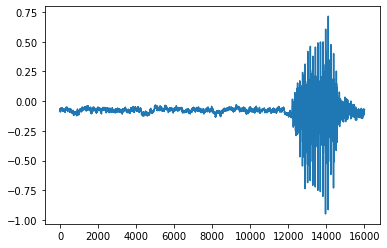

In [ ]:
plt.plot(a[0][0].t())
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
count=0
wave = []
labels = []
for i in tqdm(range(0,105829)):
    if a[i][0].shape == (1,16000):
        wave.append(a[i][0])
        labels.append(a[i][2])

100%|██████████| 105829/105829 [02:35<00:00, 678.99it/s] 


Shape of spectrogram: torch.Size([1, 40, 81])


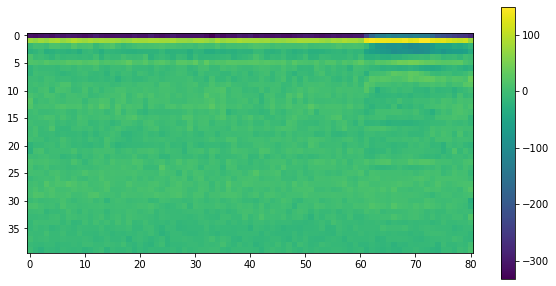

In [ ]:
specgram = torchaudio.transforms.MFCC()(wave[0])

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(figsize=(10,5))
plt.imshow(specgram[0,:,:].numpy())
plt.colorbar()
plt.show()

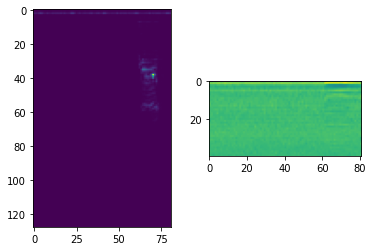

In [ ]:
specgram = torchaudio.transforms.MelSpectrogram()(wave[0])
mfcc = torchaudio.transforms.MFCC()(wave[0])


fig,ax = plt.subplots(1,2)

ax[0].imshow(specgram[0,:,:].numpy())
ax[1].imshow(mfcc[0,:,:].numpy())

In [ ]:
data_transform = 1

if data_transform == 1:
    print("MFCC Features classification")
    train_audio_transforms = nn.Sequential(
            torchaudio.transforms.MFCC(log_mels=False)
            )
    net = NN2D(num_class=35)
elif data_transform == 2:
    print("Mel Spectogram Features classification")
    train_audio_transforms = nn.Sequential(
            torchaudio.transforms.MelSpectrogram()
            )
    net = NN2DMEL(num_class=35)
else:
    train_audio_transforms = None
    net = NN(num_class=35)

MFCC Features classification


In [ ]:
labels_dict=list(set(labels))

In [ ]:
train_logits = torch.zeros((150000, 35))

dataset = SpeechDataLoaderSoft(wave,labels,labels_dict, train_audio_transforms, train_logits)

traindata, testdata = random_split(dataset, [round(len(dataset)*.8), round(len(dataset)*.2)])

trainloader = torch.utils.data.DataLoader(traindata, batch_size=100, shuffle=True)

testloader = torch.utils.data.DataLoader(testdata, batch_size=100, shuffle=True)

traindata

In [ ]:
len(traindata.indices)

76315

In [ ]:
len(dataset.labels)

95394

In [ ]:
trainloader.dataset.dataset.soft_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
# temp_test=set()
# for i in tqdm(testdata):
#     temp_test.add(i[1])
# print()
# print(len(temp_test))

# temp_train=set()
# for i in tqdm(traindata):
#     temp_train.add(i[1])
# print()
# print(len(temp_train))

In [ ]:
# print(temp_test)
# print(temp_train)

In [ ]:
#device="cpu"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

cuda:0


In [ ]:
options = {
    "epochs": 200,
    "arch": "EmoGRU",
    "k": 5,
    "gamma": 0.9,
    "t": 10
}

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(trainloader)),
                                              epochs=options["epochs"],
                                              anneal_strategy='linear') 


In [ ]:
len(trainloader)

764

In [ ]:
class KL(nn.Module):
    def __init__(self, T):
        super(KL, self).__init__()
        self.T = T

    def forward(self, y_s, p_t):
        p_s = nn.functional.log_softmax(y_s/self.T, dim=1)
        loss = nn.functional.kl_div(p_s, p_t, size_average=False) * (self.T**2) / p_s.shape[0]
        return loss

    
class Temperture_Softmax(nn.Module):
    def __init__(self, T):
        super(Temperture_Softmax, self).__init__()
        self.T = T

    def forward(self, y):    
        p = nn.functional.softmax(y/self.T, dim=1)
        return p

In [ ]:
### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss

criterion_cls = nn.CrossEntropyLoss()    


criterion_soft = Temperture_Softmax(options["t"])

criterion_kl = KL(options["t"])
criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_soft)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kl)

ModuleList(
  (0): CrossEntropyLoss()
  (1): Temperture_Softmax()
  (2): KL()
)

In [ ]:
import torch,os
from tqdm import tqdm
import torch.optim as optim


best_acc=0

def train_(net,trainloader,optim,scheduler,criterion,epoch,device,train_logits):
    print("Training..")
    net.train()
    train_loss = 0
    total = 0
    total_correct = 0
    iterator = tqdm(trainloader)

    if torch.cuda.is_available():
        train_logits=train_logits.cuda()

    for idx, (inputs,targets,softlabels,index) in enumerate(iterator):
        inputs,targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        train_logits[index] = outputs
        loss = criterion(outputs,targets)
        loss.backward()
        optim.step()
        scheduler.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch,train_loss/len(trainloader),
                                                                           total_correct*100/total))
    
    return train_loss/len(trainloader),total_correct*100/total,train_logits


def train_lwr(net,trainloader,optim,scheduler,criterion,epoch,device,train_logits):
    print("Training..")
    net.train()
    train_loss = 0
    total = 0
    total_correct = 0
    iterator = tqdm(trainloader)

    criterion_cls = criterion_list[0]
    critetion_soft = criterion_list[1]
    criterion_kl = criterion_list[2]

    if torch.cuda.is_available():
        train_logits=train_logits.cuda()

    for idx, (inputs,targets,logits,index) in enumerate(iterator):
        inputs,targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        train_logits[index] = outputs

        #loss = criterion(outputs,targets)
        soft_label = critetion_soft(logits)
        loss_cls = criterion_cls(outputs, targets)        
        loss_kl = criterion_kl(outputs, soft_label)
        if epoch<=options["k"]:
            loss = loss_cls 
        else:
            num_5 = int(epoch/options["k"])
            cure = num_5*options["k"]
            
            loss = (options["gamma"]+(1-cure/240)*(1-options["gamma"])) * loss_cls + cure/240*(1-options["gamma"])* loss_kl


        loss.backward()
        optim.step()
        scheduler.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch,train_loss/len(trainloader),
                                                                           total_correct*100/total))
    
    return train_loss/len(trainloader), total_correct*100/total, train_logits
    
def test_(net,testloader,optim,criterion,epoch,device,model_name):
    global best_acc
    print("validation")
    net.eval()
    test_loss,total,total_correct = 0,0,0
    
    iterator = tqdm(testloader)
    
    for idx, (inputs,targets,softlabels,index) in enumerate(iterator):
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    # Save checkpoint when best model
    acc = 100. * total_correct / total
    print("\nValidation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, test_loss/len(testloader), acc))

    # f = open(results_txt+".txt","a+")
    # f.write("Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%% \n" %(epoch+1, test_loss/len(testloader), acc))
    # f.close() 
        
    
    if acc > best_acc:
        
        
        if isinstance(net, torch.nn.DataParallel):
            print("multiple GPU")
            print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                'model':net.module.state_dict(),
                'model1': net.state_dict(),
                'model2': net,
                'acc':acc,
                'epoch':epoch,
            }
        
        else:
            print("not multiple GPU")
            state = {
                    'model':net,
                    'acc':acc,
                    'epoch':epoch,
                    }      
            
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+model_name+'.t7')
        best_acc = acc
        
    return test_loss/len(testloader), acc, best_acc

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(1, options["epochs"]+1):    
    if epoch<=options["k"]:
        train_loss, train_acc, train_logits = train_(net,trainloader,optimizer,scheduler,criterion,epoch,device,train_logits)
    else:
        train_loss, train_acc, train_logits = train_lwr(net,trainloader,optimizer,scheduler,criterion,epoch,device,train_logits)
    if epoch>=options["k"] and epoch%options["k"]==0:
            print('label update')
            # train_logits = train_logits.detach().cpu()
            trainloader.dataset.dataset.soft_labels = train_logits.detach()
            # train_dataset = SpeechDataLoaderSoft(wave,labels,labels_dict, train_audio_transforms, train_logits)
            # trainloader = torch.utils.data.DataLoader(traindata, batch_size=100, shuffle=True)
    test_loss, test_acc, best_acc = test_(net,testloader,optimizer,criterion,epoch,device,'SC')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

Training..


100%|██████████| 764/764 [00:52<00:00, 14.58it/s]


Epoch: [1]  loss: [4.01] Accuracy [3.43] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.71it/s]



Validation Epoch #1			Loss: 3.5529 Acc@1: 3.62%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.33it/s]


Epoch: [2]  loss: [3.56] Accuracy [3.61] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.07it/s]



Validation Epoch #2			Loss: 3.5456 Acc@1: 3.64%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.00it/s]


Epoch: [3]  loss: [3.54] Accuracy [3.79] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.53it/s]



Validation Epoch #3			Loss: 3.5366 Acc@1: 3.96%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.19it/s]


Epoch: [4]  loss: [3.53] Accuracy [4.09] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.72it/s]



Validation Epoch #4			Loss: 3.5081 Acc@1: 4.66%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.48it/s]


Epoch: [5]  loss: [3.47] Accuracy [5.14] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.71it/s]



Validation Epoch #5			Loss: 3.4301 Acc@1: 6.80%
not multiple GPU
Training..


100%|██████████| 764/764 [00:48<00:00, 15.60it/s]


Epoch: [6]  loss: [3.37] Accuracy [6.80] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.44it/s]



Validation Epoch #6			Loss: 3.3325 Acc@1: 9.19%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.13it/s]


Epoch: [7]  loss: [3.26] Accuracy [8.88] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.26it/s]



Validation Epoch #7			Loss: 3.1800 Acc@1: 13.11%
not multiple GPU
Training..


100%|██████████| 764/764 [00:48<00:00, 15.74it/s]


Epoch: [8]  loss: [3.07] Accuracy [13.16] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.03it/s]



Validation Epoch #8			Loss: 2.7568 Acc@1: 25.80%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.24it/s]


Epoch: [9]  loss: [2.75] Accuracy [21.21] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.42it/s]



Validation Epoch #9			Loss: 2.3828 Acc@1: 35.70%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.27it/s]


Epoch: [10]  loss: [2.52] Accuracy [27.16] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.51it/s]



Validation Epoch #10			Loss: 2.1796 Acc@1: 41.79%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.23it/s]


Epoch: [11]  loss: [2.35] Accuracy [31.75] 
validation


100%|██████████| 191/191 [00:13<00:00, 14.67it/s]



Validation Epoch #11			Loss: 1.9678 Acc@1: 47.79%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.29it/s]


Epoch: [12]  loss: [2.23] Accuracy [34.80] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.01it/s]



Validation Epoch #12			Loss: 1.9146 Acc@1: 48.88%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.23it/s]


Epoch: [13]  loss: [2.14] Accuracy [37.20] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.26it/s]



Validation Epoch #13			Loss: 1.8101 Acc@1: 52.07%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.00it/s]


Epoch: [14]  loss: [2.07] Accuracy [38.99] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.24it/s]



Validation Epoch #14			Loss: 1.7437 Acc@1: 55.13%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.08it/s]


Epoch: [15]  loss: [2.00] Accuracy [41.28] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.68it/s]



Validation Epoch #15			Loss: 1.6815 Acc@1: 56.81%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.13it/s]


Epoch: [16]  loss: [1.96] Accuracy [42.07] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.73it/s]



Validation Epoch #16			Loss: 1.6096 Acc@1: 58.08%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.40it/s]


Epoch: [17]  loss: [1.92] Accuracy [43.79] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.91it/s]



Validation Epoch #17			Loss: 1.5710 Acc@1: 59.05%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.07it/s]


Epoch: [18]  loss: [1.88] Accuracy [44.50] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.91it/s]



Validation Epoch #18			Loss: 1.5078 Acc@1: 61.03%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.27it/s]


Epoch: [19]  loss: [1.84] Accuracy [45.87] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.63it/s]



Validation Epoch #19			Loss: 1.5074 Acc@1: 61.57%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.29it/s]


Epoch: [20]  loss: [1.82] Accuracy [46.44] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.65it/s]



Validation Epoch #20			Loss: 1.4724 Acc@1: 62.46%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.28it/s]


Epoch: [21]  loss: [1.79] Accuracy [47.34] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.47it/s]



Validation Epoch #21			Loss: 1.4391 Acc@1: 62.83%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [22]  loss: [1.77] Accuracy [47.78] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.53it/s]



Validation Epoch #22			Loss: 1.4282 Acc@1: 63.04%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.42it/s]


Epoch: [23]  loss: [1.76] Accuracy [48.25] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.51it/s]



Validation Epoch #23			Loss: 1.4192 Acc@1: 64.14%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.09it/s]


Epoch: [24]  loss: [1.74] Accuracy [48.83] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.88it/s]



Validation Epoch #24			Loss: 1.3844 Acc@1: 64.98%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [25]  loss: [1.72] Accuracy [49.46] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.70it/s]



Validation Epoch #25			Loss: 1.3726 Acc@1: 65.47%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.45it/s]


Epoch: [26]  loss: [1.71] Accuracy [49.96] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.04it/s]



Validation Epoch #26			Loss: 1.3249 Acc@1: 66.00%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.15it/s]


Epoch: [27]  loss: [1.68] Accuracy [50.70] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.93it/s]



Validation Epoch #27			Loss: 1.3317 Acc@1: 66.55%
not multiple GPU
Training..


100%|██████████| 764/764 [00:45<00:00, 16.62it/s]


Epoch: [28]  loss: [1.67] Accuracy [50.75] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.57it/s]



Validation Epoch #28			Loss: 1.3136 Acc@1: 66.21%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.16it/s]


Epoch: [29]  loss: [1.66] Accuracy [51.21] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.55it/s]



Validation Epoch #29			Loss: 1.2876 Acc@1: 67.60%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.11it/s]


Epoch: [30]  loss: [1.65] Accuracy [51.60] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.93it/s]



Validation Epoch #30			Loss: 1.2509 Acc@1: 68.68%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.26it/s]


Epoch: [31]  loss: [1.64] Accuracy [51.81] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.97it/s]



Validation Epoch #31			Loss: 1.2549 Acc@1: 67.90%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [32]  loss: [1.63] Accuracy [52.08] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.25it/s]



Validation Epoch #32			Loss: 1.2669 Acc@1: 67.03%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.07it/s]


Epoch: [33]  loss: [1.61] Accuracy [52.77] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.03it/s]



Validation Epoch #33			Loss: 1.2143 Acc@1: 68.76%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.55it/s]


Epoch: [34]  loss: [1.60] Accuracy [52.86] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.50it/s]



Validation Epoch #34			Loss: 1.2197 Acc@1: 68.48%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.41it/s]


Epoch: [35]  loss: [1.60] Accuracy [53.21] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.95it/s]



Validation Epoch #35			Loss: 1.1903 Acc@1: 69.71%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.39it/s]


Epoch: [36]  loss: [1.58] Accuracy [53.61] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.36it/s]



Validation Epoch #36			Loss: 1.2021 Acc@1: 68.63%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.63it/s]


Epoch: [37]  loss: [1.57] Accuracy [53.78] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.10it/s]



Validation Epoch #37			Loss: 1.1201 Acc@1: 70.77%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 16.23it/s]


Epoch: [38]  loss: [1.56] Accuracy [54.02] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.93it/s]



Validation Epoch #38			Loss: 1.1075 Acc@1: 71.05%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.35it/s]


Epoch: [39]  loss: [1.55] Accuracy [54.34] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.11it/s]



Validation Epoch #39			Loss: 1.1566 Acc@1: 69.68%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.07it/s]


Epoch: [40]  loss: [1.55] Accuracy [54.50] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.96it/s]



Validation Epoch #40			Loss: 1.1064 Acc@1: 71.07%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.54it/s]


Epoch: [41]  loss: [1.55] Accuracy [54.86] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.33it/s]



Validation Epoch #41			Loss: 1.0928 Acc@1: 70.78%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.35it/s]


Epoch: [42]  loss: [1.54] Accuracy [54.89] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.70it/s]



Validation Epoch #42			Loss: 1.1275 Acc@1: 70.27%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.53it/s]


Epoch: [43]  loss: [1.53] Accuracy [55.07] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.59it/s]



Validation Epoch #43			Loss: 1.0588 Acc@1: 71.19%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.50it/s]


Epoch: [44]  loss: [1.52] Accuracy [55.49] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.92it/s]



Validation Epoch #44			Loss: 1.0682 Acc@1: 71.08%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.13it/s]


Epoch: [45]  loss: [1.52] Accuracy [55.61] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.29it/s]



Validation Epoch #45			Loss: 1.0708 Acc@1: 71.05%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.50it/s]


Epoch: [46]  loss: [1.52] Accuracy [55.64] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.91it/s]



Validation Epoch #46			Loss: 1.0529 Acc@1: 71.60%
not multiple GPU
Training..


100%|██████████| 764/764 [00:45<00:00, 16.61it/s]


Epoch: [47]  loss: [1.52] Accuracy [55.76] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.84it/s]



Validation Epoch #47			Loss: 1.0524 Acc@1: 72.24%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.40it/s]


Epoch: [48]  loss: [1.51] Accuracy [55.64] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.86it/s]



Validation Epoch #48			Loss: 1.0409 Acc@1: 71.65%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.67it/s]


Epoch: [49]  loss: [1.51] Accuracy [55.85] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.94it/s]



Validation Epoch #49			Loss: 1.0296 Acc@1: 72.18%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.61it/s]


Epoch: [50]  loss: [1.51] Accuracy [55.87] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 18.10it/s]



Validation Epoch #50			Loss: 1.0444 Acc@1: 71.83%
Training..


100%|██████████| 764/764 [00:47<00:00, 15.94it/s]


Epoch: [51]  loss: [1.51] Accuracy [55.98] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.91it/s]



Validation Epoch #51			Loss: 1.0611 Acc@1: 71.22%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.82it/s]


Epoch: [52]  loss: [1.50] Accuracy [56.29] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.76it/s]



Validation Epoch #52			Loss: 1.0256 Acc@1: 71.56%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.31it/s]


Epoch: [53]  loss: [1.51] Accuracy [56.16] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.19it/s]



Validation Epoch #53			Loss: 1.0263 Acc@1: 71.95%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.43it/s]


Epoch: [54]  loss: [1.50] Accuracy [56.27] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.63it/s]



Validation Epoch #54			Loss: 1.0123 Acc@1: 72.43%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.55it/s]


Epoch: [55]  loss: [1.50] Accuracy [56.10] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.96it/s]



Validation Epoch #55			Loss: 1.0386 Acc@1: 71.99%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.68it/s]


Epoch: [56]  loss: [1.50] Accuracy [56.26] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.18it/s]



Validation Epoch #56			Loss: 1.0372 Acc@1: 71.39%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.19it/s]


Epoch: [57]  loss: [1.50] Accuracy [56.01] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.69it/s]



Validation Epoch #57			Loss: 1.0033 Acc@1: 72.51%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.32it/s]


Epoch: [58]  loss: [1.50] Accuracy [56.44] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.10it/s]



Validation Epoch #58			Loss: 1.0515 Acc@1: 71.15%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [59]  loss: [1.50] Accuracy [56.40] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.97it/s]



Validation Epoch #59			Loss: 1.0263 Acc@1: 72.02%
Training..


100%|██████████| 764/764 [00:47<00:00, 15.93it/s]


Epoch: [60]  loss: [1.50] Accuracy [56.48] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.82it/s]



Validation Epoch #60			Loss: 1.0378 Acc@1: 71.28%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [61]  loss: [1.50] Accuracy [56.56] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.21it/s]



Validation Epoch #61			Loss: 1.0163 Acc@1: 72.30%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.77it/s]


Epoch: [62]  loss: [1.49] Accuracy [56.72] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.74it/s]



Validation Epoch #62			Loss: 1.0529 Acc@1: 71.20%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.91it/s]


Epoch: [63]  loss: [1.50] Accuracy [56.55] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.72it/s]



Validation Epoch #63			Loss: 1.0469 Acc@1: 70.89%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.29it/s]


Epoch: [64]  loss: [1.48] Accuracy [57.05] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.63it/s]



Validation Epoch #64			Loss: 1.0180 Acc@1: 71.99%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.83it/s]


Epoch: [65]  loss: [1.49] Accuracy [56.74] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 18.06it/s]



Validation Epoch #65			Loss: 1.0261 Acc@1: 71.83%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.82it/s]


Epoch: [66]  loss: [1.49] Accuracy [56.82] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.99it/s]



Validation Epoch #66			Loss: 1.0290 Acc@1: 71.35%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.21it/s]


Epoch: [67]  loss: [1.48] Accuracy [57.03] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.29it/s]



Validation Epoch #67			Loss: 0.9879 Acc@1: 73.01%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.49it/s]


Epoch: [68]  loss: [1.47] Accuracy [57.35] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.25it/s]



Validation Epoch #68			Loss: 1.0667 Acc@1: 70.11%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.84it/s]


Epoch: [69]  loss: [1.47] Accuracy [57.14] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.11it/s]



Validation Epoch #69			Loss: 1.0054 Acc@1: 72.19%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.00it/s]


Epoch: [70]  loss: [1.47] Accuracy [57.45] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 18.01it/s]



Validation Epoch #70			Loss: 1.0014 Acc@1: 72.62%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.71it/s]


Epoch: [71]  loss: [1.48] Accuracy [57.30] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.97it/s]



Validation Epoch #71			Loss: 1.0085 Acc@1: 72.18%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.74it/s]


Epoch: [72]  loss: [1.46] Accuracy [57.81] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.92it/s]



Validation Epoch #72			Loss: 1.0404 Acc@1: 70.91%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.40it/s]


Epoch: [73]  loss: [1.46] Accuracy [57.57] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.73it/s]



Validation Epoch #73			Loss: 1.0274 Acc@1: 70.89%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.70it/s]


Epoch: [74]  loss: [1.46] Accuracy [57.71] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.29it/s]



Validation Epoch #74			Loss: 1.0108 Acc@1: 71.73%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.74it/s]


Epoch: [75]  loss: [1.47] Accuracy [57.34] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.53it/s]



Validation Epoch #75			Loss: 1.0233 Acc@1: 71.40%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.55it/s]


Epoch: [76]  loss: [1.46] Accuracy [57.65] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.86it/s]



Validation Epoch #76			Loss: 0.9961 Acc@1: 72.58%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.71it/s]


Epoch: [77]  loss: [1.46] Accuracy [57.87] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.64it/s]



Validation Epoch #77			Loss: 0.9946 Acc@1: 72.08%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.61it/s]


Epoch: [78]  loss: [1.45] Accuracy [57.97] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.12it/s]



Validation Epoch #78			Loss: 0.9998 Acc@1: 72.65%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.49it/s]


Epoch: [79]  loss: [1.45] Accuracy [57.88] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.61it/s]



Validation Epoch #79			Loss: 0.9797 Acc@1: 73.46%
not multiple GPU
Training..


100%|██████████| 764/764 [00:45<00:00, 16.67it/s]


Epoch: [80]  loss: [1.45] Accuracy [58.34] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.96it/s]



Validation Epoch #80			Loss: 1.0289 Acc@1: 71.21%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.53it/s]


Epoch: [81]  loss: [1.44] Accuracy [58.39] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.45it/s]



Validation Epoch #81			Loss: 1.0462 Acc@1: 70.18%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.81it/s]


Epoch: [82]  loss: [1.45] Accuracy [58.04] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.58it/s]



Validation Epoch #82			Loss: 0.9756 Acc@1: 72.95%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.47it/s]


Epoch: [83]  loss: [1.44] Accuracy [58.16] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.05it/s]



Validation Epoch #83			Loss: 0.9900 Acc@1: 72.34%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.70it/s]


Epoch: [84]  loss: [1.44] Accuracy [58.22] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.97it/s]



Validation Epoch #84			Loss: 0.9900 Acc@1: 72.43%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.70it/s]


Epoch: [85]  loss: [1.44] Accuracy [58.29] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.73it/s]



Validation Epoch #85			Loss: 1.0250 Acc@1: 71.71%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.47it/s]


Epoch: [86]  loss: [1.44] Accuracy [58.32] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.28it/s]



Validation Epoch #86			Loss: 0.9924 Acc@1: 72.28%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.75it/s]


Epoch: [87]  loss: [1.44] Accuracy [58.46] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.56it/s]



Validation Epoch #87			Loss: 1.0073 Acc@1: 71.89%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.81it/s]


Epoch: [88]  loss: [1.43] Accuracy [58.36] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.87it/s]



Validation Epoch #88			Loss: 1.0055 Acc@1: 72.16%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.32it/s]


Epoch: [89]  loss: [1.43] Accuracy [58.41] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.24it/s]



Validation Epoch #89			Loss: 0.9787 Acc@1: 72.72%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.75it/s]


Epoch: [90]  loss: [1.43] Accuracy [58.70] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.90it/s]



Validation Epoch #90			Loss: 1.0002 Acc@1: 72.34%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.69it/s]


Epoch: [91]  loss: [1.43] Accuracy [58.50] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.01it/s]



Validation Epoch #91			Loss: 0.9574 Acc@1: 73.47%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [92]  loss: [1.43] Accuracy [58.51] 
validation


100%|██████████| 191/191 [00:12<00:00, 15.58it/s]



Validation Epoch #92			Loss: 0.9706 Acc@1: 72.86%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.73it/s]


Epoch: [93]  loss: [1.43] Accuracy [58.45] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.94it/s]



Validation Epoch #93			Loss: 0.9905 Acc@1: 72.78%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.69it/s]


Epoch: [94]  loss: [1.43] Accuracy [58.86] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.58it/s]



Validation Epoch #94			Loss: 1.0162 Acc@1: 71.66%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.50it/s]


Epoch: [95]  loss: [1.43] Accuracy [58.92] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 18.06it/s]



Validation Epoch #95			Loss: 0.9671 Acc@1: 72.53%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.22it/s]


Epoch: [96]  loss: [1.43] Accuracy [58.76] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.37it/s]



Validation Epoch #96			Loss: 1.0004 Acc@1: 71.74%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.69it/s]


Epoch: [97]  loss: [1.41] Accuracy [59.14] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.02it/s]



Validation Epoch #97			Loss: 0.9805 Acc@1: 72.39%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.64it/s]


Epoch: [98]  loss: [1.42] Accuracy [58.95] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.63it/s]



Validation Epoch #98			Loss: 1.0171 Acc@1: 71.09%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.39it/s]


Epoch: [99]  loss: [1.42] Accuracy [58.87] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.77it/s]



Validation Epoch #99			Loss: 0.9670 Acc@1: 73.49%
not multiple GPU
Training..


100%|██████████| 764/764 [00:45<00:00, 16.67it/s]


Epoch: [100]  loss: [1.42] Accuracy [59.44] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.79it/s]



Validation Epoch #100			Loss: 1.0346 Acc@1: 71.24%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.69it/s]


Epoch: [101]  loss: [1.41] Accuracy [59.29] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.08it/s]



Validation Epoch #101			Loss: 0.9582 Acc@1: 73.26%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.20it/s]


Epoch: [102]  loss: [1.41] Accuracy [59.29] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.22it/s]



Validation Epoch #102			Loss: 1.0457 Acc@1: 70.29%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.67it/s]


Epoch: [103]  loss: [1.41] Accuracy [59.39] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.86it/s]



Validation Epoch #103			Loss: 0.9967 Acc@1: 71.58%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.79it/s]


Epoch: [104]  loss: [1.40] Accuracy [59.45] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.85it/s]



Validation Epoch #104			Loss: 1.0065 Acc@1: 71.97%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [105]  loss: [1.42] Accuracy [59.13] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.66it/s]



Validation Epoch #105			Loss: 0.9720 Acc@1: 73.11%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.28it/s]


Epoch: [106]  loss: [1.41] Accuracy [59.25] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.47it/s]



Validation Epoch #106			Loss: 0.9868 Acc@1: 72.71%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.71it/s]


Epoch: [107]  loss: [1.40] Accuracy [59.32] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.23it/s]



Validation Epoch #107			Loss: 0.9637 Acc@1: 73.21%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.70it/s]


Epoch: [108]  loss: [1.41] Accuracy [59.10] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.36it/s]



Validation Epoch #108			Loss: 1.0412 Acc@1: 70.75%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.37it/s]


Epoch: [109]  loss: [1.40] Accuracy [59.41] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.96it/s]



Validation Epoch #109			Loss: 1.0013 Acc@1: 71.99%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.56it/s]


Epoch: [110]  loss: [1.41] Accuracy [59.18] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 18.26it/s]



Validation Epoch #110			Loss: 1.0046 Acc@1: 72.23%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.74it/s]


Epoch: [111]  loss: [1.40] Accuracy [59.59] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.70it/s]



Validation Epoch #111			Loss: 0.9913 Acc@1: 72.25%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.03it/s]


Epoch: [112]  loss: [1.40] Accuracy [59.61] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.19it/s]



Validation Epoch #112			Loss: 0.9452 Acc@1: 73.86%
not multiple GPU
Training..


100%|██████████| 764/764 [00:45<00:00, 16.73it/s]


Epoch: [113]  loss: [1.40] Accuracy [59.44] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.65it/s]



Validation Epoch #113			Loss: 0.9753 Acc@1: 72.80%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.49it/s]


Epoch: [114]  loss: [1.40] Accuracy [59.56] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.98it/s]



Validation Epoch #114			Loss: 0.9568 Acc@1: 73.38%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.46it/s]


Epoch: [115]  loss: [1.40] Accuracy [59.87] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.74it/s]



Validation Epoch #115			Loss: 0.9712 Acc@1: 72.82%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.73it/s]


Epoch: [116]  loss: [1.39] Accuracy [59.74] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.83it/s]



Validation Epoch #116			Loss: 0.9707 Acc@1: 72.42%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.60it/s]


Epoch: [117]  loss: [1.39] Accuracy [59.71] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.48it/s]



Validation Epoch #117			Loss: 0.9869 Acc@1: 72.18%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.61it/s]


Epoch: [118]  loss: [1.40] Accuracy [59.58] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.58it/s]



Validation Epoch #118			Loss: 0.9604 Acc@1: 73.50%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.54it/s]


Epoch: [119]  loss: [1.39] Accuracy [59.62] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.03it/s]



Validation Epoch #119			Loss: 0.9598 Acc@1: 73.34%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.61it/s]


Epoch: [120]  loss: [1.39] Accuracy [60.14] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.90it/s]



Validation Epoch #120			Loss: 0.9366 Acc@1: 74.02%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.32it/s]


Epoch: [121]  loss: [1.39] Accuracy [59.87] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.81it/s]



Validation Epoch #121			Loss: 0.9727 Acc@1: 72.97%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.29it/s]


Epoch: [122]  loss: [1.38] Accuracy [60.04] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.19it/s]



Validation Epoch #122			Loss: 0.9935 Acc@1: 72.37%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.66it/s]


Epoch: [123]  loss: [1.39] Accuracy [60.00] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.12it/s]



Validation Epoch #123			Loss: 0.9664 Acc@1: 72.68%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.60it/s]


Epoch: [124]  loss: [1.38] Accuracy [60.12] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.04it/s]



Validation Epoch #124			Loss: 0.9478 Acc@1: 73.68%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.45it/s]


Epoch: [125]  loss: [1.38] Accuracy [60.20] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.98it/s]



Validation Epoch #125			Loss: 0.9741 Acc@1: 72.89%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.64it/s]


Epoch: [126]  loss: [1.38] Accuracy [60.05] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.67it/s]



Validation Epoch #126			Loss: 0.9559 Acc@1: 73.14%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.71it/s]


Epoch: [127]  loss: [1.38] Accuracy [59.83] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.09it/s]



Validation Epoch #127			Loss: 0.9653 Acc@1: 72.86%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.50it/s]


Epoch: [128]  loss: [1.38] Accuracy [60.11] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.90it/s]



Validation Epoch #128			Loss: 0.9561 Acc@1: 72.57%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.69it/s]


Epoch: [129]  loss: [1.38] Accuracy [60.14] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.18it/s]



Validation Epoch #129			Loss: 0.9616 Acc@1: 72.95%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.71it/s]


Epoch: [130]  loss: [1.38] Accuracy [60.25] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.38it/s]



Validation Epoch #130			Loss: 0.9735 Acc@1: 72.77%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.11it/s]


Epoch: [131]  loss: [1.38] Accuracy [60.42] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.58it/s]



Validation Epoch #131			Loss: 0.9620 Acc@1: 73.39%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.68it/s]


Epoch: [132]  loss: [1.38] Accuracy [60.03] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.83it/s]



Validation Epoch #132			Loss: 0.9690 Acc@1: 72.84%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [133]  loss: [1.38] Accuracy [59.89] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.06it/s]



Validation Epoch #133			Loss: 0.9573 Acc@1: 72.66%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.32it/s]


Epoch: [134]  loss: [1.38] Accuracy [60.18] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.85it/s]



Validation Epoch #134			Loss: 0.9393 Acc@1: 73.64%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.56it/s]


Epoch: [135]  loss: [1.38] Accuracy [60.51] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.89it/s]



Validation Epoch #135			Loss: 0.9696 Acc@1: 72.58%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.75it/s]


Epoch: [136]  loss: [1.38] Accuracy [60.25] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.35it/s]



Validation Epoch #136			Loss: 0.9559 Acc@1: 73.13%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.71it/s]


Epoch: [137]  loss: [1.37] Accuracy [60.29] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.87it/s]



Validation Epoch #137			Loss: 0.9433 Acc@1: 73.36%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.30it/s]


Epoch: [138]  loss: [1.36] Accuracy [60.52] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.58it/s]



Validation Epoch #138			Loss: 0.9658 Acc@1: 73.10%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.63it/s]


Epoch: [139]  loss: [1.37] Accuracy [60.51] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.15it/s]



Validation Epoch #139			Loss: 0.9545 Acc@1: 73.42%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.69it/s]


Epoch: [140]  loss: [1.37] Accuracy [60.45] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.99it/s]



Validation Epoch #140			Loss: 0.9289 Acc@1: 74.09%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.27it/s]


Epoch: [141]  loss: [1.36] Accuracy [60.62] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.89it/s]



Validation Epoch #141			Loss: 0.9340 Acc@1: 73.76%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.37it/s]


Epoch: [142]  loss: [1.37] Accuracy [60.63] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.88it/s]



Validation Epoch #142			Loss: 0.9418 Acc@1: 73.46%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.52it/s]


Epoch: [143]  loss: [1.36] Accuracy [60.66] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.47it/s]



Validation Epoch #143			Loss: 0.9420 Acc@1: 73.91%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.15it/s]


Epoch: [144]  loss: [1.36] Accuracy [60.82] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.95it/s]



Validation Epoch #144			Loss: 0.9184 Acc@1: 74.21%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.33it/s]


Epoch: [145]  loss: [1.36] Accuracy [60.82] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.91it/s]



Validation Epoch #145			Loss: 0.9298 Acc@1: 73.84%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.28it/s]


Epoch: [146]  loss: [1.36] Accuracy [60.81] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.03it/s]



Validation Epoch #146			Loss: 0.9513 Acc@1: 73.63%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.13it/s]


Epoch: [147]  loss: [1.35] Accuracy [60.82] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.66it/s]



Validation Epoch #147			Loss: 0.9566 Acc@1: 73.37%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.40it/s]


Epoch: [148]  loss: [1.36] Accuracy [60.75] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.89it/s]



Validation Epoch #148			Loss: 0.9575 Acc@1: 72.99%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.36it/s]


Epoch: [149]  loss: [1.36] Accuracy [60.85] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.33it/s]



Validation Epoch #149			Loss: 0.9582 Acc@1: 73.32%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.29it/s]


Epoch: [150]  loss: [1.36] Accuracy [60.61] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.99it/s]



Validation Epoch #150			Loss: 0.9503 Acc@1: 73.61%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [151]  loss: [1.36] Accuracy [60.87] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.32it/s]



Validation Epoch #151			Loss: 0.9196 Acc@1: 74.71%
not multiple GPU
Training..


100%|██████████| 764/764 [00:46<00:00, 16.33it/s]


Epoch: [152]  loss: [1.35] Accuracy [60.96] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.88it/s]



Validation Epoch #152			Loss: 0.9532 Acc@1: 73.52%
Training..


100%|██████████| 764/764 [00:50<00:00, 15.09it/s]


Epoch: [153]  loss: [1.35] Accuracy [60.74] 
validation


100%|██████████| 191/191 [00:12<00:00, 15.17it/s]



Validation Epoch #153			Loss: 0.9410 Acc@1: 73.90%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.25it/s]


Epoch: [154]  loss: [1.35] Accuracy [61.04] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.72it/s]



Validation Epoch #154			Loss: 0.9521 Acc@1: 73.21%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.24it/s]


Epoch: [155]  loss: [1.35] Accuracy [60.88] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.63it/s]



Validation Epoch #155			Loss: 0.9483 Acc@1: 73.48%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.49it/s]


Epoch: [156]  loss: [1.35] Accuracy [61.01] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.86it/s]



Validation Epoch #156			Loss: 0.9321 Acc@1: 73.92%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.41it/s]


Epoch: [157]  loss: [1.35] Accuracy [60.88] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.74it/s]



Validation Epoch #157			Loss: 0.9304 Acc@1: 74.08%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.44it/s]


Epoch: [158]  loss: [1.34] Accuracy [61.14] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.76it/s]



Validation Epoch #158			Loss: 0.9157 Acc@1: 74.64%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.50it/s]


Epoch: [159]  loss: [1.35] Accuracy [61.17] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.05it/s]



Validation Epoch #159			Loss: 0.9386 Acc@1: 73.89%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.35it/s]


Epoch: [160]  loss: [1.34] Accuracy [61.22] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.87it/s]



Validation Epoch #160			Loss: 0.9316 Acc@1: 73.82%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.15it/s]


Epoch: [161]  loss: [1.35] Accuracy [60.92] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.40it/s]



Validation Epoch #161			Loss: 0.9341 Acc@1: 74.04%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [162]  loss: [1.34] Accuracy [61.14] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.99it/s]



Validation Epoch #162			Loss: 0.9224 Acc@1: 74.31%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.25it/s]


Epoch: [163]  loss: [1.34] Accuracy [61.43] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.65it/s]



Validation Epoch #163			Loss: 0.9354 Acc@1: 73.60%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.58it/s]


Epoch: [164]  loss: [1.35] Accuracy [61.11] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.29it/s]



Validation Epoch #164			Loss: 0.9285 Acc@1: 74.03%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.51it/s]


Epoch: [165]  loss: [1.34] Accuracy [61.29] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.42it/s]



Validation Epoch #165			Loss: 0.9342 Acc@1: 74.04%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.67it/s]


Epoch: [166]  loss: [1.33] Accuracy [61.54] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.65it/s]



Validation Epoch #166			Loss: 0.9470 Acc@1: 73.62%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.48it/s]


Epoch: [167]  loss: [1.34] Accuracy [61.39] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.54it/s]



Validation Epoch #167			Loss: 0.9236 Acc@1: 74.23%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.31it/s]


Epoch: [168]  loss: [1.34] Accuracy [61.18] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.87it/s]



Validation Epoch #168			Loss: 0.9174 Acc@1: 74.64%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.80it/s]


Epoch: [169]  loss: [1.33] Accuracy [61.64] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.41it/s]



Validation Epoch #169			Loss: 0.9525 Acc@1: 73.52%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.25it/s]


Epoch: [170]  loss: [1.33] Accuracy [61.64] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.89it/s]



Validation Epoch #170			Loss: 0.9404 Acc@1: 73.43%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.28it/s]


Epoch: [171]  loss: [1.33] Accuracy [61.57] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.38it/s]



Validation Epoch #171			Loss: 0.9497 Acc@1: 73.54%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.55it/s]


Epoch: [172]  loss: [1.33] Accuracy [61.64] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.72it/s]



Validation Epoch #172			Loss: 0.9463 Acc@1: 73.68%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.41it/s]


Epoch: [173]  loss: [1.33] Accuracy [61.68] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.02it/s]



Validation Epoch #173			Loss: 0.9419 Acc@1: 73.76%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.27it/s]


Epoch: [174]  loss: [1.33] Accuracy [61.71] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.93it/s]



Validation Epoch #174			Loss: 0.9381 Acc@1: 73.93%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [175]  loss: [1.33] Accuracy [61.50] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.76it/s]



Validation Epoch #175			Loss: 0.9201 Acc@1: 74.74%
not multiple GPU
Training..


100%|██████████| 764/764 [00:47<00:00, 15.92it/s]


Epoch: [176]  loss: [1.33] Accuracy [61.59] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.77it/s]



Validation Epoch #176			Loss: 0.9130 Acc@1: 74.66%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [177]  loss: [1.33] Accuracy [61.46] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.46it/s]



Validation Epoch #177			Loss: 0.9507 Acc@1: 73.44%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.32it/s]


Epoch: [178]  loss: [1.33] Accuracy [61.62] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.43it/s]



Validation Epoch #178			Loss: 0.9200 Acc@1: 74.50%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.68it/s]


Epoch: [179]  loss: [1.32] Accuracy [61.77] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.64it/s]



Validation Epoch #179			Loss: 0.9159 Acc@1: 74.52%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.78it/s]


Epoch: [180]  loss: [1.33] Accuracy [61.75] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.64it/s]



Validation Epoch #180			Loss: 0.9205 Acc@1: 74.39%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.20it/s]


Epoch: [181]  loss: [1.33] Accuracy [61.64] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.70it/s]



Validation Epoch #181			Loss: 0.9280 Acc@1: 74.10%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.62it/s]


Epoch: [182]  loss: [1.32] Accuracy [61.84] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.42it/s]



Validation Epoch #182			Loss: 0.9269 Acc@1: 74.18%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.25it/s]


Epoch: [183]  loss: [1.32] Accuracy [61.83] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.11it/s]



Validation Epoch #183			Loss: 0.9247 Acc@1: 74.36%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.21it/s]


Epoch: [184]  loss: [1.32] Accuracy [61.94] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.30it/s]



Validation Epoch #184			Loss: 0.9213 Acc@1: 74.39%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.59it/s]


Epoch: [185]  loss: [1.32] Accuracy [61.67] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.84it/s]



Validation Epoch #185			Loss: 0.9364 Acc@1: 73.86%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.06it/s]


Epoch: [186]  loss: [1.32] Accuracy [61.73] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.51it/s]



Validation Epoch #186			Loss: 0.9302 Acc@1: 73.98%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.48it/s]


Epoch: [187]  loss: [1.33] Accuracy [61.74] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.63it/s]



Validation Epoch #187			Loss: 0.9207 Acc@1: 74.18%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.43it/s]


Epoch: [188]  loss: [1.32] Accuracy [61.85] 
validation


100%|██████████| 191/191 [00:11<00:00, 17.28it/s]



Validation Epoch #188			Loss: 0.9205 Acc@1: 74.33%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.58it/s]


Epoch: [189]  loss: [1.32] Accuracy [61.94] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.64it/s]



Validation Epoch #189			Loss: 0.9198 Acc@1: 74.41%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.62it/s]


Epoch: [190]  loss: [1.32] Accuracy [61.73] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.93it/s]



Validation Epoch #190			Loss: 0.9183 Acc@1: 74.52%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.08it/s]


Epoch: [191]  loss: [1.32] Accuracy [61.86] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.76it/s]



Validation Epoch #191			Loss: 0.9147 Acc@1: 74.57%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.52it/s]


Epoch: [192]  loss: [1.32] Accuracy [61.90] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.79it/s]



Validation Epoch #192			Loss: 0.9336 Acc@1: 73.93%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.38it/s]


Epoch: [193]  loss: [1.32] Accuracy [62.15] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.62it/s]



Validation Epoch #193			Loss: 0.9332 Acc@1: 73.86%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.16it/s]


Epoch: [194]  loss: [1.32] Accuracy [62.11] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.78it/s]



Validation Epoch #194			Loss: 0.9255 Acc@1: 74.44%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.57it/s]


Epoch: [195]  loss: [1.31] Accuracy [62.05] 
label update
validation


100%|██████████| 191/191 [00:11<00:00, 16.59it/s]



Validation Epoch #195			Loss: 0.9232 Acc@1: 74.31%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.44it/s]


Epoch: [196]  loss: [1.32] Accuracy [61.82] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.77it/s]



Validation Epoch #196			Loss: 0.9195 Acc@1: 74.51%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.44it/s]


Epoch: [197]  loss: [1.32] Accuracy [61.88] 
validation


100%|██████████| 191/191 [00:10<00:00, 17.97it/s]



Validation Epoch #197			Loss: 0.9255 Acc@1: 74.26%
Training..


100%|██████████| 764/764 [00:47<00:00, 16.19it/s]


Epoch: [198]  loss: [1.31] Accuracy [62.03] 
validation


100%|██████████| 191/191 [00:11<00:00, 16.76it/s]



Validation Epoch #198			Loss: 0.9248 Acc@1: 74.28%
Training..


100%|██████████| 764/764 [00:45<00:00, 16.63it/s]


Epoch: [199]  loss: [1.31] Accuracy [62.32] 
validation


100%|██████████| 191/191 [00:10<00:00, 18.01it/s]



Validation Epoch #199			Loss: 0.9247 Acc@1: 74.22%
Training..


100%|██████████| 764/764 [00:46<00:00, 16.32it/s]


Epoch: [200]  loss: [1.31] Accuracy [62.21] 
label update
validation


100%|██████████| 191/191 [00:10<00:00, 17.38it/s]


Validation Epoch #200			Loss: 0.9244 Acc@1: 74.21%


In [ ]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
x = np.arange(1, len(train_losses)+1)
y_train = train_losses
y_val = test_losses

# smoothing the labels.
X_Y_Spline = make_interp_spline(x, y_val)
X_val = np.linspace(min(x), max(x), 500)
Y_val = X_Y_Spline(X_val)
 
X_Y_Spline = make_interp_spline(x, y_train)
X_train = np.linspace(min(x), max(x), 500)
Y_train = X_Y_Spline(X_train)

# Plotting the Graph
plt.plot(X_val, Y_val,label = "Validation Loss")
plt.plot(X_train, Y_train,label = "Train Loss")
plt.title("Speech Command Loss w/ LWR for 200 epochs.")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: ignored

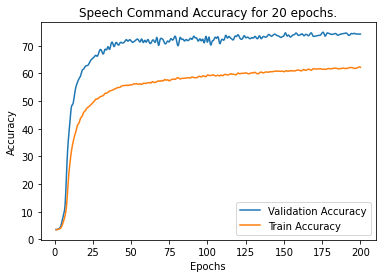

In [ ]:
y_train = train_accs
y_val = test_accs

# smoothing the labels.
X_Y_Spline = make_interp_spline(x, y_val)
X_val = np.linspace(min(x), max(x), 500)
Y_val = X_Y_Spline(X_val)
 
X_Y_Spline = make_interp_spline(x, y_train)
X_train = np.linspace(min(x), max(x), 500)
Y_train = X_Y_Spline(X_train)

# Plotting the Graph
plt.plot(X_val, Y_val,label = "Validation Accuracy")
plt.plot(X_train, Y_train,label = "Train Accuracy")
plt.title("Speech Command Accuracy w/ LWR for 200 epochs.")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()